<a href="https://colab.research.google.com/github/jmsmg/TIL/blob/main/%EA%B3%B5%EB%AA%A8%EC%A0%84/%EC%88%98%EC%83%81%EC%9E%91/%5B%EC%9E%A5%EC%96%B4%2C_Private%201%EC%9C%84%2C%20%EC%A0%90%EC%88%98%2098.76%5D%20Pycaret%20%ED%99%9C%EC%9A%A9%20%EC%A3%BC%EC%B0%A8%20%EC%88%98%EC%9A%94%20%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 참고한 공유 게시글 
- 파베르 님의 코드 공유 [주차수요 예측 EDA & Catboost Baseline]  
전처리하는 부분에서 많은 도움이 되었습니다. 감사합니다.  
https://dacon.io/competitions/official/235745/codeshare/2851?page=1&dtype=recent

- Jay Hong 님의 토크 게시글 [Data Leakage에 대한 개인적인 정리입니다]  
Data Leakage.. 너무 어렵습니다.  초심자를 위한 Dacon의 가이드라인이 있었으면 합니다. Jay Hong 님 감사합니다.  
https://dacon.io/competitions/official/235745/talkboard/403895?page=1&dtype=recent

- 흔들리는 인덕원역 님의 코드 공유 [Beseline 코드보다 높은 점수 받아 보자]  
데이터 이해하는 부분에서 많은 도움이 되었습니다. 감사합니다.   
https://dacon.io/competitions/official/235745/codeshare/2860?page=1&dtype=recent

## 1. 각종 설치 & 한글 폰트 설정 & 패키지 불러오기 & 경로 설정 

In [1]:
#패키지 불러오기 및 각종 설치 & 폰트 설정 한방에 
import matplotlib 
%matplotlib inline

import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

!apt-get update -qq
!apt-get install fonts-nanum* -qq

font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
matplotlib.rcParams['axes.unicode_minus'] = False

!pip install catboost
!pip install pycaret
from tqdm.notebook import tqdm
from pycaret.regression import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

NanumBarunGothic


In [2]:
from google.colab import drive  
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
import os
workspace_path = '/gdrive/My Drive/Datasets/' 
data_path = os.path.join(workspace_path, '235745_parking_data')

## 2. 데이터 탐색 및 전처리

* 토크 게시판에 올라온 오류 데이터 모두를 일단 포함하고 2번과 3번은 항상 제거하고 사용했으며 1번 오류 데이터에 대해서는 실험을 계속 진행하다 마지막에는 가장 큰 값들만 제거하는 방향으로 진행한 것 같습니다. 
* 다른 전처리는 대부분 코드 공유에 올라온 ['파베르'님의 주차수요 예측 EDA & Catboost Baseline](https://dacon.io/competitions/official/235745/codeshare/2851?page=1&dtype=recent) 를 참고했습니다. 공유 감사합니다.

In [4]:
age_gender = pd.read_csv(os.path.join(data_path, 'age_gender_info.csv')) # 지역 임대주택 나이별, 성별 인구 분포
train = pd.read_csv(os.path.join(data_path, 'train.csv')) # 학습용 데이터
test = pd.read_csv(os.path.join(data_path, 'test.csv')) # 테스트 데이터

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          1022 non-null   object 
 1   총세대수                          1022 non-null   int64  
 2   임대건물구분                        1022 non-null   object 
 3   지역                            1022 non-null   object 
 4   공급유형                          1022 non-null   object 
 5   전용면적                          1022 non-null   float64
 6   전용면적별세대수                      1022 non-null   int64  
 7   공가수                           1022 non-null   float64
 8   자격유형                          1020 non-null   object 
 9   임대보증금                         842 non-null    object 
 10  임대료                           842 non-null    object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  980 non-null    float64
 12  도보 10분거리 내 버스정류장 수            1022 non-null   float64
 13  단지내

## 2-1. 임대보증금, 임대료 결측치 처리
- 결측치에 - 처리 되어있어 nan 결측치로 변경
- 임대 보증금, 임대료 object를 float 형태로 변경
  > int형을 쓰지않은 이유

In [6]:
train.loc[train.임대보증금=='-', '임대보증금'] = np.nan
test.loc[test.임대보증금=='-', '임대보증금'] = np.nan
train['임대보증금'] = train['임대보증금'].astype(float)
test['임대보증금'] = test['임대보증금'].astype(float)

train.loc[train.임대료=='-', '임대료'] = np.nan
test.loc[test.임대료=='-', '임대료'] = np.nan
train['임대료'] = train['임대료'].astype(float)
test['임대료'] = test['임대료'].astype(float)

In [7]:
test.head(140)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,H,22830000.0,189840.0,0.0,2.0,683.0
1,C1072,754,아파트,경기도,국민임대,46.81,30,14.0,A,36048000.0,249930.0,0.0,2.0,683.0
2,C1072,754,아파트,경기도,국민임대,46.90,112,14.0,H,36048000.0,249930.0,0.0,2.0,683.0
3,C1072,754,아파트,경기도,국민임대,46.90,120,14.0,H,36048000.0,249930.0,0.0,2.0,683.0
4,C1072,754,아파트,경기도,국민임대,51.46,60,14.0,H,43497000.0,296780.0,0.0,2.0,683.0
5,C1072,754,아파트,경기도,국민임대,51.71,51,14.0,H,43497000.0,296780.0,0.0,2.0,683.0
6,C1072,754,아파트,경기도,국민임대,51.96,198,14.0,H,43497000.0,296780.0,0.0,2.0,683.0
7,C1072,754,아파트,경기도,국민임대,51.96,67,14.0,H,43497000.0,296780.0,0.0,2.0,683.0
8,C1128,1354,아파트,경기도,국민임대,39.79,368,9.0,H,22830000.0,189840.0,0.0,3.0,1216.0
9,C1128,1354,아파트,경기도,국민임대,39.79,30,9.0,H,22830000.0,189840.0,0.0,3.0,1216.0


## 2-2. 데이터 오류 삭제
- [데이터 오류](https://dacon.io/competitions/official/235745/talkboard/403708?page=1&dtype=recent)를 데이콘에서 발표
1. 전용면적별 세대수 합계와 총세대수가 일치하지 않는 경우
  - 전용면적별 세대수 합계와 총 세대수가 일치하지않아 가장 큰 차이를 보이는 4개 단지 삭제

2. 동일한 단지에 단지코드가 2개로 부여되어 단지코드 ․ 총세대수 ․ 주차면수 ․ 등록차량대수 등에서 오류 발생
  - 코드가 2개로 부여되어 2배로 보이는 경우 삭제

3. 단지코드 등 기입 실수로 단지코드 ․ 총세대수 ․ 주차면수 ․ 등록차량대수 등에서 오류 발생
  - 그냥 기입 실수로 공개된 것 삭제

In [8]:
##1번 데이터 오류 (가장 큰 차이를 보이는 단지 4개에 대해 삭제 (토크 게시판에 크기순으로 나열되어있음))
train = train[train.단지코드 != 'C1804']
train = train[train.단지코드 != 'C2405']
train = train[train.단지코드 != 'C1740']
train = train[train.단지코드 != 'C1206']
# train = train[train.단지코드 != 'C2470']
# train = train[train.단지코드 != 'C1024']
# train = train[train.단지코드 != 'C1344']
# train = train[train.단지코드 != 'C2620']
# train = train[train.단지코드 != 'C2497']
# train = train[train.단지코드 != 'C1490']

# train = train[train.단지코드 != 'C1925']
# train = train[train.단지코드 != 'C1312']
# train = train[train.단지코드 != 'C2013']
# train = train[train.단지코드 != 'C1424']
# train = train[train.단지코드 != 'C2520']
# train = train[train.단지코드 != 'C2319']
# train = train[train.단지코드 != 'C1850']
# train = train[train.단지코드 != 'C1068']
# train = train[train.단지코드 != 'C2644']
# train = train[train.단지코드 != 'C2156']

# train = train[train.단지코드 != 'C2453']
# train = train[train.단지코드 != 'C1910']
# train = train[train.단지코드 != 'C2139']
# train = train[train.단지코드 != 'C2508']
# train = train[train.단지코드 != 'C1695']
# train = train[train.단지코드 != 'C2556']
# train = train[train.단지코드 != 'C2362']
# train = train[train.단지코드 != 'C2568']
# train = train[train.단지코드 != 'C2245']
# train = train[train.단지코드 != 'C2549']

# train = train[train.단지코드 != 'C1584']
# train = train[train.단지코드 != 'C2298']
# train = train[train.단지코드 != 'C2225']
# train = train[train.단지코드 != 'C1218']
# train = train[train.단지코드 != 'C1970']
# train = train[train.단지코드 != 'C1732']
# train = train[train.단지코드 != 'C2433']
# train = train[train.단지코드 != 'C1894']
# train = train[train.단지코드 != 'C1156']
# train = train[train.단지코드 != 'C2142']

# train = train[train.단지코드 != 'C2186']
# train = train[train.단지코드 != 'C2411']
# train = train[train.단지코드 != 'C1812']
# train = train[train.단지코드 != 'C1030']
# train = train[train.단지코드 != 'C1749']
# train = train[train.단지코드 != 'C1349']
# train = train[train.단지코드 != 'C2043']
# train = train[train.단지코드 != 'C1229']
# train = train[train.단지코드 != 'C2363']
# train = train[train.단지코드 != 'C1414']

# train = train[train.단지코드 != 'C2174']
# train = train[train.단지코드 != 'C2404']
# train = train[train.단지코드 != 'C1683']
# train = train[train.단지코드 != 'C1038']
# train = train[train.단지코드 != 'C2456']
# train = train[train.단지코드 != 'C1266']
# train = train[train.단지코드 != 'C1267']
# train = train[train.단지코드 != 'C2189']

##2번 데이터오류 
train = train[train.단지코드 != 'C2085']
train = train[train.단지코드 != 'C1397']
train = train[train.단지코드 != 'C2431']
train = train[train.단지코드 != 'C1649']
train = train[train.단지코드 != 'C1036']

##3번 데이터 오류
train = train[train.단지코드 != 'C1095']
train = train[train.단지코드 != 'C2051']
train = train[train.단지코드 != 'C1218']
train = train[train.단지코드 != 'C1894']
train = train[train.단지코드 != 'C2483']
train = train[train.단지코드 != 'C1502']
train = train[train.단지코드 != 'C1988']

## 2-3. 버스 정류장 및 지하철 수 이상치 처리
- test에 50이라는 너무 이상한 값이 존재 >> train의 mean으로 보정
- 단지내 10분 거리에 버스정류장이 50개는 말이 안됨(걷는 속도가 아니라 뛰어도 50개 안나옴)

In [9]:
train['도보 10분거리 내 버스정류장 수'].unique()

array([ 3.,  1.,  2.,  6., 10.,  5.,  4.,  7., 12., 14.,  8.,  0., 20.,
       11., 16., 15., 19.])

In [10]:
test['도보 10분거리 내 버스정류장 수'].unique()

array([ 2.,  3., 16.,  6.,  1.,  4.,  5.,  8., 10., 13.,  7., 11., 50.,
       12., 14., 18., 15., 19., 17.])

In [11]:
# 결측치 0으로 처리
train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'] = train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].fillna(0)
test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'] = test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].fillna(0)
train['도보 10분거리 내 버스정류장 수'] = train['도보 10분거리 내 버스정류장 수'].fillna(0)

In [12]:
test[test['도보 10분거리 내 버스정류장 수']==50]   ##상식적으로 있을 수 없는 값이라고 판단 

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
383,C1852,898,아파트,경기도,국민임대,39.59,219,6.0,H,23720000.0,197230.0,0.0,50.0,785.0
384,C1852,898,아파트,경기도,국민임대,39.72,56,6.0,A,23720000.0,197230.0,0.0,50.0,785.0
385,C1852,898,아파트,경기도,국민임대,39.72,44,6.0,A,23720000.0,197230.0,0.0,50.0,785.0
386,C1852,898,아파트,경기도,국민임대,46.90,46,6.0,A,37454000.0,259660.0,0.0,50.0,785.0
387,C1852,898,아파트,경기도,국민임대,46.90,22,6.0,A,37454000.0,259660.0,0.0,50.0,785.0
388,C1852,898,아파트,경기도,국민임대,46.90,225,6.0,H,37454000.0,259660.0,0.0,50.0,785.0
389,C1852,898,아파트,경기도,국민임대,51.93,136,6.0,H,45193000.0,308350.0,0.0,50.0,785.0
390,C1852,898,아파트,경기도,국민임대,51.93,44,6.0,H,45193000.0,308350.0,0.0,50.0,785.0
391,C1852,898,아파트,경기도,국민임대,59.61,106,6.0,H,61674000.0,370790.0,0.0,50.0,785.0


In [13]:
# train[train['지역'] == '경기도']['도보 10분거리 내 버스정류장 수'].max() 

## 2-4. 버스정류장 수 이상치를 평균값으로 전환
- 10분 이내 50개의 버스정류장 수를 평균값으로 대체

In [14]:
test.loc[test['도보 10분거리 내 버스정류장 수'] == 50, '도보 10분거리 내 버스정류장 수'] = train['도보 10분거리 내 버스정류장 수'].mean()
##train의 평균 값으로 처리 


##train[train['지역'] == '경기도']['도보 10분거리 내 버스정류장 수'].max() 
## 50정도의 큰 값이라면 해당 지역내 가장 큰 값으로 대신해도 된다고 판단, test의 통계치는 참고할 수 없으니 train의 max값으로 처리  

## ⭐⭐ 2-5. 임대료 및 임대보증금 처리
* data leakage에 대한 이해 불충분으로 test 통계치로 처리하다가 많은 분들의 생각 공유와 dacon 측의 답변으로 대회 기간 내 바꿀 수 있었습니다. 생각 공유해주신 많은 분과 [토크 게시판에 글(Data Leakage에 대한 개인적인 정리입니다) 올려주신 'Jay Hong'님 ](https://dacon.io/competitions/official/235745/talkboard/403895?page=1&dtype=recent) 감사합니다. 많이 배우고 있습니다! 
* 하지만 이 부분에서 데이콘측에서 정확한 가이드라인이 있었으면 더 좋겠다는 생각입니다.. 초보자 입장에서 너무 많은 착각을 할 수 있고 이로 인해 수상 취소까지 갈 수 있는 만큼 명확한 규정이 있었으면 좋겠습니다.

In [15]:
# train = train.drop(columns=['임대료', '임대보증금']) 살리는 게 더 좋은 점수를 가져옴 
# test = test.drop(columns=['임대료', '임대보증금'])
# train

## 2-6. 임대 상가 column 이상치, 결측치 처리
- 다른 공급 유형이면 몰라도 임대 상가에 한해서는 임대료와 임대보증금이 0원이라는 것은 말이 안 된다고 판단해 **임대상가**는 해당 **지역의 train의 임대료와 임대보증금 평균값**으로 처리했습니다.

In [16]:
# 결측치 0원 처리

#임대료 처리 
train.loc[train['공급유형'] == '공공분양', '임대료'] = train['임대료'].fillna(0)
train.loc[train['공급유형'] == '장기전세', '임대료'] = train['임대료'].fillna(0)
train.loc[train['공급유형'] == '국민임대', '임대료'] = train['임대료'].fillna(0)
train.loc[train['공급유형'] == '행복주택', '임대료'] = train['임대료'].fillna(0)

#임대보증금 처리
train.loc[train['공급유형'] == '공공분양', '임대보증금'] = train['임대보증금'].fillna(0)
train.loc[train['공급유형'] == '장기전세', '임대보증금'] = train['임대보증금'].fillna(0)
train.loc[train['공급유형'] == '국민임대', '임대보증금'] = train['임대보증금'].fillna(0)
train.loc[train['공급유형'] == '행복주택', '임대보증금'] = train['임대보증금'].fillna(0)

In [17]:
# 임대상가 결측치를 평균값으로 반환

#임대 상가의 임대료 처리 
train.loc[train['지역'] == '부산광역시', '임대료'] = train['임대료'].fillna(train[train['지역'] == '부산광역시']['임대료'].mean())
train.loc[train['지역'] == '대전광역시', '임대료'] = train['임대료'].fillna(train[train['지역'] == '대전광역시']['임대료'].mean())
train.loc[train['지역'] == '경상남도', '임대료'] = train['임대료'].fillna(train[train['지역'] == '경상남도']['임대료'].mean())
train.loc[train['지역'] == '충청남도', '임대료'] = train['임대료'].fillna(train[train['지역'] == '충청남도']['임대료'].mean())
train.loc[train['지역'] == '강원도', '임대료'] = train['임대료'].fillna(train[train['지역'] == '강원도']['임대료'].mean())
train.loc[train['지역'] == '제주특별자치도', '임대료'] = train['임대료'].fillna(train[train['지역'] == '제주특별자치도']['임대료'].mean())

#임대 상가의 임대보증금 처리 
train.loc[train['지역'] == '부산광역시', '임대보증금'] = train['임대보증금'].fillna(train[train['지역'] == '부산광역시']['임대보증금'].mean())
train.loc[train['지역'] == '대전광역시', '임대보증금'] = train['임대보증금'].fillna(train[train['지역'] == '대전광역시']['임대보증금'].mean())
train.loc[train['지역'] == '경상남도', '임대보증금'] = train['임대보증금'].fillna(train[train['지역'] == '경상남도']['임대보증금'].mean())
train.loc[train['지역'] == '충청남도', '임대보증금'] = train['임대보증금'].fillna(train[train['지역'] == '충청남도']['임대보증금'].mean())
train.loc[train['지역'] == '강원도', '임대보증금'] = train['임대보증금'].fillna(train[train['지역'] == '강원도']['임대보증금'].mean())
train.loc[train['지역'] == '제주특별자치도', '임대보증금'] = train['임대보증금'].fillna(train[train['지역'] == '제주특별자치도']['임대보증금'].mean())

In [18]:
# train.groupby(['공급유형'], as_index=False)['임대료'].mean()

In [19]:
#임대료 처리 
test.loc[test['공급유형'] == '영구임대', '임대료'] = test['임대료'].fillna(0)
test.loc[test['공급유형'] == '행복주택', '임대료'] = test['임대료'].fillna(0)

#임대보증금 처리
test.loc[test['공급유형'] == '영구임대', '임대보증금'] = test['임대보증금'].fillna(0)
test.loc[test['공급유형'] == '행복주택', '임대보증금'] = test['임대보증금'].fillna(0)

In [20]:
# data leakage이기 때문에 train data 기준으로 test 처리

#임대 상가의 임대료 처리  (test 특성 기준 test null 값 처리는 data leakage 여서 train의 지역 기준으로 test 처리)
test.loc[test['지역'] == '부산광역시', '임대료'] = test['임대료'].fillna(train[train['지역'] == '부산광역시']['임대료'].mean())
test.loc[test['지역'] == '대전광역시', '임대료'] = test['임대료'].fillna(train[train['지역'] == '대전광역시']['임대료'].mean())
test.loc[test['지역'] == '울산광역시', '임대료'] = test['임대료'].fillna(train[train['지역'] == '울산광역시']['임대료'].mean())
test.loc[test['지역'] == '충청남도', '임대료'] = test['임대료'].fillna(train[train['지역'] == '충청남도']['임대료'].mean())
test.loc[test['지역'] == '강원도', '임대료'] = test['임대료'].fillna(train[train['지역'] == '강원도']['임대료'].mean())  


#임대 상가의 임대보증금 처리 
test.loc[test['지역'] == '부산광역시', '임대보증금'] = test['임대보증금'].fillna(train[train['지역'] == '부산광역시']['임대보증금'].mean())
test.loc[test['지역'] == '대전광역시', '임대보증금'] = test['임대보증금'].fillna(train[train['지역'] == '대전광역시']['임대보증금'].mean())
test.loc[test['지역'] == '울산광역시', '임대보증금'] = test['임대보증금'].fillna(train[train['지역'] == '울산광역시']['임대보증금'].mean())
test.loc[test['지역'] == '충청남도', '임대보증금'] = test['임대보증금'].fillna(train[train['지역'] == '충청남도']['임대보증금'].mean())
test.loc[test['지역'] == '강원도', '임대보증금'] = test['임대보증금'].fillna(train[train['지역'] == '강원도']['임대보증금'].mean())

## 2-7. 자격유형 처리
- 국민 임대아파트에 살려면 재산, 청약 등 점수가 필요한 것으로 결측치를 제외한 모든 데이터가 A인것으로 보아 결측치를 A로 채워도 무방
- 이와 유사하게 영구임대는 모두 C, 임대상가는 모두 D

In [21]:
test[test.자격유형.isnull()]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000.0,37470.0,0.0,2.0,840.0
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000.0,44770.0,0.0,2.0,173.0


In [22]:
test[test.단지코드=='C2411'] #같은 단지의 자격유형이 모두 A이므로 누락된 것으로 생각하고 A로 채워도 될 듯

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
193,C2411,962,아파트,경상남도,국민임대,39.43,56,25.0,A,11992000.0,100720.0,0.0,2.0,840.0
194,C2411,962,아파트,경상남도,국민임대,39.72,336,25.0,A,11992000.0,100720.0,0.0,2.0,840.0
195,C2411,962,아파트,경상남도,국민임대,39.82,179,25.0,A,11992000.0,100720.0,0.0,2.0,840.0
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000.0,37470.0,0.0,2.0,840.0
197,C2411,962,아파트,경상남도,국민임대,51.93,150,25.0,A,21586000.0,171480.0,0.0,2.0,840.0


In [23]:
test.loc[test.단지코드.isin(['C2411']) & test.자격유형.isnull(), '자격유형'] = 'A'

In [24]:
test[test.단지코드=='C2253'] #같은 단지의 임대상가가 아닌 영구임대 유형의 경우 모두 C이므로 C로 채워도 될 듯

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2.249000e+06,44770.00000,0.0,2.0,173.0
259,C2253,1161,아파트,강원도,영구임대,31.32,239,0.0,C,3.731000e+06,83020.00000,0.0,2.0,173.0
260,C2253,1161,아파트,강원도,영구임대,31.32,149,0.0,C,3.731000e+06,83020.00000,0.0,2.0,173.0
261,C2253,1161,상가,강원도,임대상가,13.77,1,0.0,D,1.772704e+07,179965.25974,0.0,2.0,173.0
262,C2253,1161,상가,강원도,임대상가,22.89,1,0.0,D,1.772704e+07,179965.25974,0.0,2.0,173.0
263,C2253,1161,상가,강원도,임대상가,22.91,1,0.0,D,1.772704e+07,179965.25974,0.0,2.0,173.0
264,C2253,1161,상가,강원도,임대상가,23.79,1,0.0,D,1.772704e+07,179965.25974,0.0,2.0,173.0
265,C2253,1161,상가,강원도,임대상가,23.79,1,0.0,D,1.772704e+07,179965.25974,0.0,2.0,173.0
266,C2253,1161,상가,강원도,임대상가,23.86,1,0.0,D,1.772704e+07,179965.25974,0.0,2.0,173.0
267,C2253,1161,상가,강원도,임대상가,23.86,1,0.0,D,1.772704e+07,179965.25974,0.0,2.0,173.0


In [25]:
test.loc[test.단지코드.isin(['C2253']) & test.자격유형.isnull(), '자격유형'] = 'C'

## 2-8. 공급 + 자격 으로 새로운 column 생성
* 공급유형과 자격유형이 어느정도의 관련성이 있을 것으로 예상해 이를 합쳐서 새로운 특성으로 바꿨습니다. 실제로 고유값이 그렇게 많이 만들어지지는 않았음을 확인할 수 있었습니다. 

> 영구임대 D가 남았음

In [26]:
train['공급_자격'] = train.apply(lambda r : r['공급유형'] + '_' +r['자격유형'], axis=1)
test['공급_자격'] = test.apply(lambda r : r['공급유형'] + '_' +r['자격유형'], axis=1)
train

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,공급_자격
8,C2515,545,아파트,경상남도,국민임대,33.48,276,17.0,A,9216000.0,82940.0,0.0,3.0,624.0,205.0,국민임대_A
9,C2515,545,아파트,경상남도,국민임대,39.60,60,17.0,A,12672000.0,107130.0,0.0,3.0,624.0,205.0,국민임대_A
10,C2515,545,아파트,경상남도,국민임대,39.60,20,17.0,A,12672000.0,107130.0,0.0,3.0,624.0,205.0,국민임대_A
11,C2515,545,아파트,경상남도,국민임대,46.90,38,17.0,A,18433000.0,149760.0,0.0,3.0,624.0,205.0,국민임대_A
12,C2515,545,아파트,경상남도,국민임대,46.90,19,17.0,A,18433000.0,149760.0,0.0,3.0,624.0,205.0,국민임대_A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,C2532,239,아파트,강원도,국민임대,49.20,19,7.0,A,11346000.0,116090.0,0.0,1.0,166.0,146.0,국민임대_A
2948,C2532,239,아파트,강원도,국민임대,51.08,34,7.0,A,14005000.0,142310.0,0.0,1.0,166.0,146.0,국민임대_A
2949,C2532,239,아파트,강원도,국민임대,51.73,34,7.0,A,14005000.0,142310.0,0.0,1.0,166.0,146.0,국민임대_A
2950,C2532,239,아파트,강원도,국민임대,51.96,114,7.0,A,14005000.0,142310.0,0.0,1.0,166.0,146.0,국민임대_A


In [27]:
print("train - test (공급_자격 차집합) : ", set(train.공급_자격).difference(set(test.공급_자격))) ##train에만 있는 값들 찾아보기 
# train.공급_자격 - test.공급_자격
print("test - train (공급_자격 차집합) : ", set(test.공급_자격).difference(set(train.공급_자격)))
# test.공급_자격 - train.공급_자격

train - test (공급_자격 차집합) :  {'영구임대_F', '영구임대_A', '공공분양_D', '행복주택_O', '장기전세_A', '국민임대_B', '공공임대(5년)_A', '영구임대_E'}
test - train (공급_자격 차집합) :  {'영구임대_D'}


In [28]:
train = train[train.공급_자격 != '공공분양_D']
train = train[train.공급_자격 != '공공임대(5년)_A']
train = train[train.공급_자격 != '국민임대_B']
train = train[train.공급_자격 != '영구임대_A']
train = train[train.공급_자격 != '영구임대_E']
train = train[train.공급_자격 != '영구임대_F']
train = train[train.공급_자격 != '장기전세_A']
train = train[train.공급_자격 != '행복주택_O']

test = test[test.공급_자격 != '영구임대_D']

## 😰 2-9. 전용면적으로 전처리(???)

In [29]:
train['전용면적'] = train['전용면적']//2*2  ##현재는 2*2일 때 가장 성능이 좋았었다. 
test['전용면적'] = test['전용면적']//2*2

In [30]:
print("train - test (전용면적 차집합) : ", set(train.전용면적).difference(set(test.전용면적))) ##train에만 있는 값들 찾아보기 
print("test - train (전용면적 차집합) : ", set(test.전용면적).difference(set(train.전용면적)))

train - test (전용면적 차집합) :  {66.0, 136.0, 72.0, 108.0, 52.0, 406.0, 56.0, 126.0, 316.0, 62.0}
test - train (전용면적 차집합) :  {8.0, 252.0}


In [31]:
train = train[train.전용면적 != 52]##
train = train[train.전용면적 != 56]##
train = train[train.전용면적 != 62]##
train = train[train.전용면적 != 64]
train = train[train.전용면적 != 66] ##
train = train[train.전용면적 != 72] ##
train = train[train.전용면적 != 78]
train = train[train.전용면적 != 108] ##
train = train[train.전용면적 != 126]##
train = train[train.전용면적 != 136]##
train = train[train.전용면적 != 316]##
train = train[train.전용면적 != 406]##

test = test[test.전용면적 != 8]
test = test[test.전용면적 != 252]

In [32]:
print("train - test (지역 차집합) : ", set(train.지역).difference(set(test.지역))) ##train에만 있는 값들 찾아보기 
print("test - train (지역 차집합) : ", set(test.지역).difference(set(train.지역)))

train - test (지역 차집합) :  {'서울특별시'}
test - train (지역 차집합) :  set()


In [33]:
train = train[train.지역 != '서울특별시'] ##컬럼의 특정 값이면 제거하는 방법 

## 2-10. age_gender에서 미성년자(20대 미만) 비율만 가져와서 join
이 값이 높다면 등록차량 수가 낮을 것이라는 판단이었습니다.

In [34]:
minors = ['10대미만(여자)', '10대미만(남자)', '10대(여자)', '10대(남자)']
age_gender['미성년자'] = age_gender[minors].sum(axis=1) 

# age data에서 미성년자 칼럼 생성

In [35]:
# 기준열 이름이 다를때 지역 이름으로 붙임

train = train.merge(age_gender, left_on= ["지역"], right_on= ["지역"], how='left')
test = test.merge(age_gender, left_on= ["지역"], right_on= ["지역"], how='left')

# 3. 데이터 정리 및 병합

In [36]:
# drop_duplicates() 중복 값 제거함수로 확인
train.shape, train.drop_duplicates().shape

((2719, 39), (2311, 39))

In [37]:
# drop_duplicates() 중복 값 제거함수로 확인
test.shape, test.drop_duplicates().shape

((1017, 38), (891, 38))

In [38]:
# drop_duplicates() 중복 제거
train = train.drop_duplicates()
test = test.drop_duplicates()

In [39]:
# 필요한 칼럼만 불러와서 중복값 제거하며 단지코드(인덱스) 삽입 

unique_cols = ['총세대수', '지역', '공가수', '미성년자', 
               '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
               '도보 10분거리 내 버스정류장 수',
               '단지내주차면수', '등록차량수']

# set_index함수로 여러개의 단지코드(인덱스)를 설정
train_agg = train.set_index('단지코드')[unique_cols].drop_duplicates()

# test에서 List comprehension을 활용하여 등록차량수가 없는 unique_cols에서 등록차량수를 제거한 값

test_agg = test.set_index('단지코드')[[col for col in unique_cols if col!='등록차량수']].drop_duplicates()

In [40]:
train_agg.head()

,총세대수,지역,공가수,미성년자,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
단지코드,,,,,,,,
C2515,545,경상남도,17.0,0.163127,0.0,3.0,624.0,205.0
C1407,1216,대전광역시,13.0,0.140571,1.0,1.0,1285.0,1064.0
C1470,696,전라북도,14.0,0.176920,0.0,2.0,645.0,553.0
C1898,566,전라북도,9.0,0.176920,0.0,6.0,517.0,415.0
C1244,1722,경기도,10.0,0.184072,0.0,10.0,1483.0,1804.0


In [41]:
test_agg.head()

,총세대수,지역,공가수,미성년자,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
단지코드,,,,,,,
C1072,754,경기도,14.0,0.184072,0.0,2.0,683.0
C1128,1354,경기도,9.0,0.184072,0.0,3.0,1216.0
C1456,619,부산광역시,18.0,0.113143,0.0,16.0,547.0
C1840,593,전라북도,7.0,0.176920,0.0,3.0,543.0
C1332,1297,경기도,11.0,0.184072,0.0,2.0,1112.0


### 임대 건물 구분, 전용면적 별 세대수, 임대보증금 
등과 같이 처리가 애매한 값은 각 단지 별 mean값이나 고유값 개수로 처리

In [42]:
# groupby() 함수로 단지코드별 평균값을 구함

tr = train.groupby(['단지코드']).mean() ##같은 단지코드 안에서의 평균 값, max 값 등은 data leakage가 아닌 것으로 보임 
ts = test.groupby(['단지코드']).mean()

train_agg['전용면적별세대수 평균'] = tr['전용면적별세대수']
test_agg['전용면적별세대수 평균'] = ts['전용면적별세대수']

train_agg['임대보증금 평균'] = tr['임대보증금']
test_agg['임대보증금 평균'] = ts['임대보증금']

train_agg['임대료 평균'] = tr['임대료']
test_agg['임대료 평균'] = ts['임대료']

In [43]:
# groupby로 단지코드로 묶었음
# nunique(dropna=False) 고유값의수 (결측값 포함)

tr = train.groupby(['단지코드']).nunique(dropna=False)
ts = test.groupby(['단지코드']).nunique(dropna=False)

train_agg['임대건물구분'] = tr['임대건물구분']
test_agg['임대건물구분'] = ts['임대건물구분']

### ⭐⭐categorical 값들 펼치기 '파베르'님 코드 공유 참고 

In [44]:
def reshape_cat_features(data, cast_col, value_col):
    # drop_duplicates 단지코드와 cast_col의 칼럼만 뽑아냄
    # .assign은 카운터값을 1로 두는 칼럼 생성
    # 단지코드를 인덱스로 두고
    # 칼럼명 : cast_col(변수), 칼럼 값 value_col의 칼럼
    # 결측치 0 처리
    res = data.drop_duplicates(['단지코드', cast_col]).assign(counter=1).pivot(index='단지코드', columns=cast_col, values=value_col).fillna(0)
    # column. name 
    res.columns.name = None
    # cloumns = 위에서 cast_col로 들어온 것을 comprehension으로 계속 돌면서 넣어줌

    res = res.rename(columns={col:col for col in res.columns})
    return res

In [72]:
reshape_cat_features(data=train, cast_col='공급_자격', value_col='counter')

,공공임대(10년)_A,공공임대(50년)_A,공공임대(분납)_A,국민임대_A,국민임대_E,국민임대_G,국민임대_H,영구임대_C,영구임대_I,임대상가_D,행복주택_J,행복주택_K,행복주택_L,행복주택_M,행복주택_N
단지코드,,,,,,,,,,,,,,,
C1000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
C1005,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1013,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1014,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C2663,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C2666,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C2670,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
def reshape_cat_features_plus_underbar(data, cast_col, value_col):
    # 
    res = data.drop_duplicates(['단지코드', cast_col]).assign(counter=1).pivot(index='단지코드', columns=cast_col, values=value_col).fillna(0)
    res.columns.name = None
    res = res.rename(columns={col:cast_col+'_'+ str(col) for col in res.columns})
    return res

In [47]:
reshape_cat_features_plus_underbar(data=train, cast_col='전용면적', value_col='counter')

,전용면적_12.0,전용면적_14.0,전용면적_16.0,전용면적_18.0,전용면적_20.0,전용면적_22.0,전용면적_24.0,전용면적_26.0,전용면적_28.0,전용면적_30.0,전용면적_32.0,전용면적_34.0,전용면적_36.0,전용면적_38.0,전용면적_40.0,전용면적_42.0,전용면적_44.0,전용면적_46.0,전용면적_48.0,전용면적_50.0,전용면적_54.0,전용면적_58.0,전용면적_60.0,전용면적_74.0,전용면적_82.0,전용면적_84.0,전용면적_240.0,전용면적_248.0,전용면적_400.0,전용면적_404.0,전용면적_582.0
단지코드,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1004,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
C1005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
# 사용하지 않을 함수

def transportation_level(x): ##대중교통 값 조정 (원래 있던 값을 drop 하지 않았을 때 더 성능이 잘 나옴)
  result = 0
  if x <= 0 :
    result = 5
  elif 1 <= x <= 2:
    result = 4
  elif 3 <= x <= 4 :
    result = 3
  elif 5 <= x <= 6 :
    result = 2
  elif 7 <= x:
    result = 1
  return result

### 다 합친 데이터 생성 및 추가 처리(log)

In [73]:
# 위에서 만든 onehot vector형태를 세로로 붙여줌

train_data = pd.concat([train_agg.drop(columns=['지역']), reshape_cat_features(data=train, cast_col='공급_자격', value_col='counter'),
                        reshape_cat_features(data=train, cast_col='지역', value_col='counter'),
                       reshape_cat_features_plus_underbar(data=train, cast_col='전용면적', value_col='counter')
                       ], axis=1)

test_data = pd.concat([test_agg.drop(columns=['지역']), reshape_cat_features(data=test, cast_col='공급_자격', value_col='counter'),
                       reshape_cat_features(data=test, cast_col='지역', value_col='counter'),
                       reshape_cat_features_plus_underbar(data=test, cast_col='전용면적', value_col='counter')
                      ], axis=1)

# 총세대-빈집/총 세대를 해서 실제 거주율을 도출해냄

train_data['실거주율'] = (train_agg['총세대수'] - train_agg['공가수'])/train_agg['총세대수']
test_data['실거주율'] = (test_agg['총세대수'] - test_agg['공가수'])/test_agg['총세대수']

# 10분 이내 지하철역 수, 10분 내 버스장류장 수로 근처 대중교통 현황을 알아냄

transport = ['도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수']
train_data['대중교통현황'] = train_agg[transport].sum(axis=1)
test_data['대중교통현황'] = test_agg[transport].sum(axis=1)

# train_data['대중교통현황'] = train_data['대중교통현황'].apply(transportation_level) 
# test_data['대중교통현황'] = test_data['대중교통현황'].apply(transportation_level)

In [76]:
test_data

,총세대수,공가수,미성년자,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,전용면적별세대수 평균,임대보증금 평균,임대료 평균,임대건물구분,공공임대(10년)_A,공공임대(50년)_A,공공임대(분납)_A,국민임대_A,국민임대_E,국민임대_G,국민임대_H,영구임대_C,영구임대_I,임대상가_D,행복주택_J,행복주택_K,행복주택_L,행복주택_M,행복주택_N,강원도,경기도,경상남도,경상북도,광주광역시,대구광역시,대전광역시,부산광역시,세종특별자치시,울산광역시,전라남도,전라북도,제주특별자치도,충청남도,충청북도,전용면적_12.0,전용면적_14.0,전용면적_16.0,전용면적_18.0,전용면적_20.0,전용면적_22.0,전용면적_24.0,전용면적_26.0,전용면적_28.0,전용면적_30.0,전용면적_32.0,전용면적_34.0,전용면적_36.0,전용면적_38.0,전용면적_40.0,전용면적_42.0,전용면적_44.0,전용면적_46.0,전용면적_48.0,전용면적_50.0,전용면적_54.0,전용면적_58.0,전용면적_60.0,전용면적_74.0,전용면적_82.0,전용면적_84.0,전용면적_240.0,전용면적_248.0,전용면적_400.0,전용면적_404.0,전용면적_582.0,실거주율,대중교통현황
C1072,754,14.0,0.184072,0.0,2.0,683.0,94.250000,3.812025e+07,265843.750000,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.981432,2.0
C1128,1354,9.0,0.184072,0.0,3.0,1216.0,150.444444,3.412500e+07,245516.666667,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.993353,3.0
C1456,619,18.0,0.113143,0.0,16.0,547.0,66.625000,3.370488e+07,222290.000000,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.970921,16.0
C1840,593,7.0,0.176920,0.0,3.0,543.0,148.250000,1.892425e+07,123150.000000,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.988196,3.0
C1332,1297,11.0,0.184072,0.0,2.0,1112.0,162.125000,4.133450e+07,292880.000000,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.991519,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C2456,349,17.0,0.194559,0.0,4.0,270.0,86.500000,1.222875e+07,155082.500000,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.951289,4.0
C1266,596,35.0,0.191395,0.0,1.0,593.0,118.200000,1.435520e+07,199878.000000,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.941275,1.0
C2152,120,9.0,0.163568,0.0,1.0,40.0,60.000000,0.000000e+00,0.000000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.925000,1.0
C1267,675,38.0,0.163127,0.0,1.0,467.0,60.909091,8.294364e+06,84548.181818,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.943704,1.0


In [74]:
train_data.shape, test_data.shape

((397, 74), (150, 73))

### ⭐⭐ .corr() 함수
- 피어슨 상관계수로 표현
- 변수간 연관관계를 숫자로 표현

In [75]:
train_data.corr()['등록차량수'].sort_values() ##단지내주차면수가 너무 큰 상관관계성을 띄고 있음

임대건물구분        -0.311428
임대상가_D        -0.311428
영구임대_C        -0.299785
전용면적_30.0     -0.275161
전용면적_16.0     -0.192724
                 ...   
공공임대(10년)_A    0.398108
임대료 평균         0.433797
총세대수           0.604368
단지내주차면수        0.848526
등록차량수          1.000000
Name: 등록차량수, Length: 74, dtype: float64

## ⭐⭐ np.log1p() 함수 
로그 함수(logarithm function)

넘파이에서 제공하는 로그함수는 4개입니다. np.log, np.log10, np.log2, np.log1p입니다.

np.log는 밑이 자연상수 e인 자연로그 값을 반환합니다. np.log10, np.log2는 각각 밑이 10, 2인 로그값을 반환합니다.

np.log1p는 밑이 자연상수 
e
면서 
1
+
x
의 입력값을 반환합니다. 수식으로 적으면 f(x)=ln(1+x)와 동일

In [52]:
train_data['주차면수/총세대'] = train_data['단지내주차면수'] / train_data['총세대수']
test_data['주차면수/총세대'] = test_data['단지내주차면수'] / test_data['총세대수']

## log취하기
train_data['총세대수log'] = np.log1p(train_data['총세대수'])
test_data['총세대수log'] = np.log1p(test_data['총세대수'])

train_data['단지내주차면수log'] = np.log1p(train_data['단지내주차면수'])
test_data['단지내주차면수log'] = np.log1p(test_data['단지내주차면수'])

train_data['단지내주차면수/100'] = train_data['단지내주차면수']/100
test_data['단지내주차면수/100'] = test_data['단지내주차면수']/100

train_data['버스지하철log'] = np.log1p(train_data['대중교통현황'])
test_data['버스지하철log'] = np.log1p(test_data['대중교통현황'])

train_data['전용면적별세대수 평균 log'] = np.log1p(train_data['전용면적별세대수 평균'])
test_data['전용면적별세대수 평균 log'] = np.log1p(test_data['전용면적별세대수 평균'])

train_data['임대보증금 평균 log'] = np.log1p(train_data['임대보증금 평균'])
test_data['임대보증금 평균 log'] = np.log1p(test_data['임대보증금 평균'])

train_data['임대료 평균 log'] = np.log1p(train_data['임대료 평균'])
test_data['임대료 평균 log'] = np.log1p(test_data['임대료 평균'])

##target 값 비율로 바꾸고 필요 없는 특성 제거 (이를 target encoding 으로 칭하는 듯 함..?)
train_data['주차면수대비등록확률'] = train_data['등록차량수'] / train_data['단지내주차면수']
train_data = train_data.drop(columns=['등록차량수'])

# train_data = train_data.drop(columns=['실거주가구'])
# test_data = test_data.drop(columns=['실거주가구'])

# train_data = train_data.drop(columns=['단지내주차면수'])
# test_data = test_data.drop(columns=['단지내주차면수'])

In [53]:
train_data.head()

,총세대수,공가수,미성년자,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,전용면적별세대수 평균,임대보증금 평균,임대료 평균,임대건물구분,공공임대(10년)_A,공공임대(50년)_A,공공임대(분납)_A,국민임대_A,국민임대_E,국민임대_G,국민임대_H,영구임대_C,영구임대_I,임대상가_D,행복주택_J,행복주택_K,행복주택_L,행복주택_M,행복주택_N,강원도,경기도,경상남도,경상북도,광주광역시,대구광역시,대전광역시,부산광역시,세종특별자치시,울산광역시,전라남도,전라북도,제주특별자치도,충청남도,충청북도,전용면적_12.0,전용면적_14.0,전용면적_16.0,전용면적_18.0,전용면적_20.0,전용면적_22.0,전용면적_24.0,전용면적_26.0,전용면적_28.0,전용면적_30.0,전용면적_32.0,전용면적_34.0,전용면적_36.0,전용면적_38.0,전용면적_40.0,전용면적_42.0,전용면적_44.0,전용면적_46.0,전용면적_48.0,전용면적_50.0,전용면적_54.0,전용면적_58.0,전용면적_60.0,전용면적_74.0,전용면적_82.0,전용면적_84.0,전용면적_240.0,전용면적_248.0,전용면적_400.0,전용면적_404.0,전용면적_582.0,실거주율,대중교통현황,주차면수/총세대,총세대수log,단지내주차면수log,단지내주차면수/100,버스지하철log,전용면적별세대수 평균 log,임대보증금 평균 log,임대료 평균 log,주차면수대비등록확률
C2515,545,17.0,0.163127,0.0,3.0,624.0,77.857143,1.678714e+07,139557.142857,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.968807,3.0,1.144954,6.302619,6.437752,6.24,1.386294,4.367638,16.636124,11.846237,0.328526
C1407,1216,13.0,0.140571,1.0,1.0,1285.0,114.250000,2.598438e+07,165956.250000,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.989309,2.0,1.056743,7.104144,7.159292,12.85,1.098612,4.747104,17.073006,12.019486,0.828016
C1470,696,14.0,0.176920,0.0,2.0,645.0,174.000000,1.772275e+07,120150.000000,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.979885,2.0,0.926724,6.546785,6.470800,6.45,1.098612,5.164786,16.690360,11.696505,0.857364
C1898,566,9.0,0.176920,0.0,6.0,517.0,94.333333,1.742233e+07,119148.333333,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.984099,6.0,0.913428,6.340359,6.249975,5.17,1.945910,4.557380,16.673264,11.688133,0.802708
C1244,1722,10.0,0.184072,0.0,10.0,1483.0,142.818182,4.033873e+07,276856.363636,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.994193,10.0,0.861208,7.451822,7.302496,14.83,2.397895,4.968550,17.512823,12.531258,1.216453


In [54]:
test_data.head()

,총세대수,공가수,미성년자,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,전용면적별세대수 평균,임대보증금 평균,임대료 평균,임대건물구분,공공임대(10년)_A,공공임대(50년)_A,공공임대(분납)_A,국민임대_A,국민임대_E,국민임대_G,국민임대_H,영구임대_C,영구임대_I,임대상가_D,행복주택_J,행복주택_K,행복주택_L,행복주택_M,행복주택_N,강원도,경기도,경상남도,경상북도,광주광역시,대구광역시,대전광역시,부산광역시,세종특별자치시,울산광역시,전라남도,전라북도,제주특별자치도,충청남도,충청북도,전용면적_12.0,전용면적_14.0,전용면적_16.0,전용면적_18.0,전용면적_20.0,전용면적_22.0,전용면적_24.0,전용면적_26.0,전용면적_28.0,전용면적_30.0,전용면적_32.0,전용면적_34.0,전용면적_36.0,전용면적_38.0,전용면적_40.0,전용면적_42.0,전용면적_44.0,전용면적_46.0,전용면적_48.0,전용면적_50.0,전용면적_54.0,전용면적_58.0,전용면적_60.0,전용면적_74.0,전용면적_82.0,전용면적_84.0,전용면적_240.0,전용면적_248.0,전용면적_400.0,전용면적_404.0,전용면적_582.0,실거주율,대중교통현황,주차면수/총세대,총세대수log,단지내주차면수log,단지내주차면수/100,버스지하철log,전용면적별세대수 평균 log,임대보증금 평균 log,임대료 평균 log
C1072,754,14.0,0.184072,0.0,2.0,683.0,94.250000,38120250.0,265843.750000,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.981432,2.0,0.905836,6.626718,6.527958,6.83,1.098612,4.556505,17.456256,12.490668
C1128,1354,9.0,0.184072,0.0,3.0,1216.0,150.444444,34125000.0,245516.666667,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.993353,3.0,0.898080,7.211557,7.104144,12.16,1.386294,5.020219,17.345541,12.411124
C1456,619,18.0,0.113143,0.0,16.0,547.0,66.625000,33704875.0,222290.000000,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.970921,16.0,0.883683,6.429719,6.306275,5.47,2.833213,4.213978,17.333153,12.311743
C1840,593,7.0,0.176920,0.0,3.0,543.0,148.250000,18924250.0,123150.000000,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.988196,3.0,0.915683,6.386879,6.298949,5.43,1.386294,5.005623,16.755955,11.721167
C1332,1297,11.0,0.184072,0.0,2.0,1112.0,162.125000,41334500.0,292880.000000,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.991519,2.0,0.857363,7.168580,7.014814,11.12,1.098612,5.094517,17.537208,12.587522


## Pycaret으로 모델 생성 
* 해당 대회가 워낙 데이터도 이상하고 이상치들이 많이 존재해 모델을 너무 잘 만들었다간 private 점수가 많이 안 좋을 것으로 예상했습니다. 
* 애초부터 model에 대해 신경을 안 쓰기로 마음 먹고 Pycaret에 집어넣고 가장 성능이 잘 나오는 5개로 블랜딩해서 최종 모델을 생성했습니다. 
* 실제로 모델 튜닝을 더 진행하고 파라미터 값 등을 더 좋게 변경해줬을 때 public score가 더 떨어지거나 cv 값이 더 떨어졌습니다. 저만 그랬던 것인지는 잘 모르겠습니다.. 

In [77]:
setup?

In [55]:
# 파이캐럿 setup(트레이닝 데이터, 타겟데이터, 사이즈 )

reg = setup(data=train_data,
            target='주차면수대비등록확률',
            session_id = 201,
            numeric_imputation = 'mean',
            fold_shuffle = True,
            numeric_features=list(train_data.drop(columns = ['주차면수대비등록확률']).columns),
            ignore_low_variance = True,
            combine_rare_levels = True, rare_level_threshold = 0.05,
            remove_multicollinearity = True, multicollinearity_threshold = 0.90,
            normalize = True,
            silent= True)

,Description,Value
0,session_id,201
1,Target,주차면수대비등록확률
2,Original Data,"(397, 82)"
3,Missing Values,False
4,Numeric Features,81
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(277, 40)"


In [56]:
best_5_l = compare_models(sort='MAE', n_select=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.1985,0.0753,0.2706,0.2295,0.1391,0.2628,0.556
catboost,CatBoost Regressor,0.2004,0.0767,0.2736,0.2085,0.1404,0.2624,4.853
br,Bayesian Ridge,0.2052,0.0765,0.2719,0.2132,0.1399,0.2699,0.015
lightgbm,Light Gradient Boosting Machine,0.2078,0.0810,0.2809,0.1605,0.1431,0.2664,0.090
gbr,Gradient Boosting Regressor,0.2120,0.0845,0.2854,0.1368,0.1462,0.2755,0.118
et,Extra Trees Regressor,0.2120,0.0915,0.2987,0.0583,0.1501,0.2758,0.461
knn,K Neighbors Regressor,0.2126,0.0805,0.2812,0.1620,0.1450,0.2832,0.061
ridge,Ridge Regression,0.2150,0.0891,0.2925,0.0802,0.1476,0.2834,0.014
omp,Orthogonal Matching Pursuit,0.2152,0.0820,0.2824,0.1645,0.1442,0.2788,0.014
lr,Linear Regression,0.2190,0.0969,0.3031,0.0032,0.1497,0.2893,0.291


In [57]:
best_5_l ## 각 모델 튜닝하려고 추출했던 것이지만 과대적합 관련해서 default 값으로 진행 

[RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=201, verbose=0, warm_start=False),
 BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
               compute_score=False, copy_X=True, fit_intercept=True,
               lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
               normalize=False, tol=0.001, verbose=False),
 LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,

In [58]:
blended_l = blend_models(estimator_list= best_5_l, fold=5, optimize='MAE')
pred_holdout = predict_model(blended_l)
final_model_l = finalize_model(blended_l)
pred_esb_l = predict_model(final_model_l, test_data) 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1819,0.0901,0.3002,0.1841,0.1353,0.1908
1,0.2162,0.0808,0.2842,0.2599,0.1549,0.3462
2,0.1704,0.0505,0.2247,0.2862,0.1147,0.2010
3,0.2037,0.0712,0.2668,0.2749,0.1437,0.3007
4,0.2060,0.0705,0.2656,0.3145,0.1358,0.2479
Mean,0.1956,0.0726,0.2683,0.2639,0.1369,0.2573
SD,0.0169,0.0132,0.0252,0.0437,0.0132,0.0591


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.2075,0.0819,0.2862,0.2505,0.1575,0.3819


## 모델 시각화

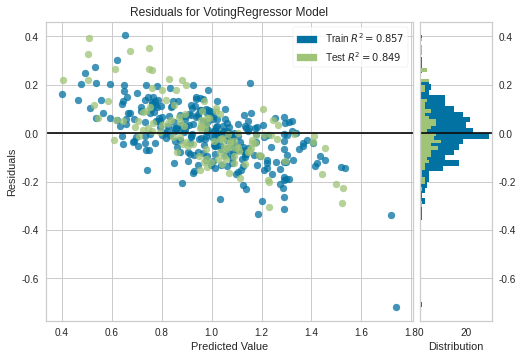

In [59]:
plot_model(final_model_l, plot='residuals') # 잔차 그래프

In [60]:
# plot_model(final_model_l, plot='learning')

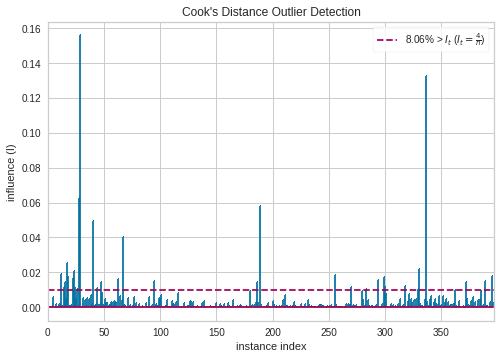

In [61]:
plot_model(final_model_l, plot='cooks') ## 심한 아웃 라이어들이 존재하는 것을 볼 수 있습니다..

In [62]:
rf_model = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1888,0.0577,0.2402,0.3248,0.1269,0.2528
1,0.1871,0.1375,0.3709,-0.0827,0.1568,0.1522
2,0.1994,0.0634,0.2518,0.3384,0.1316,0.2618
3,0.2322,0.0933,0.3054,0.2266,0.1710,0.4205
4,0.1543,0.0371,0.1926,0.4983,0.1051,0.2118
5,0.2024,0.0745,0.2730,-0.1471,0.1362,0.2142
6,0.1910,0.0603,0.2455,0.4116,0.1347,0.2923
7,0.2013,0.0756,0.2749,0.1881,0.1479,0.3013
8,0.2033,0.0605,0.2459,0.3254,0.1257,0.2310
9,0.2254,0.0936,0.3059,0.2113,0.1550,0.2904


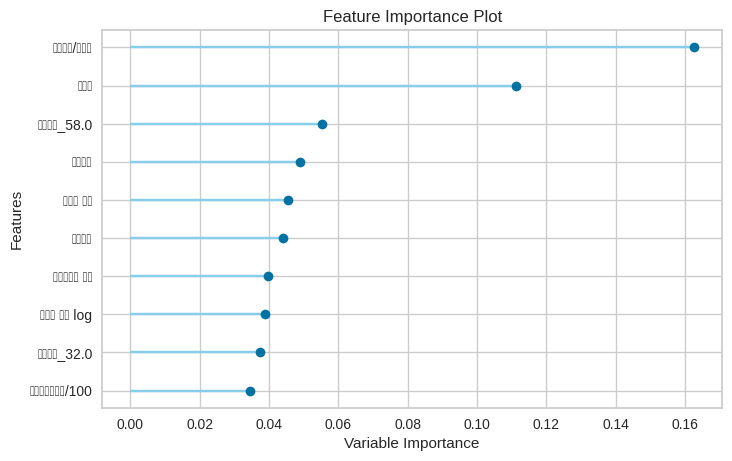

In [63]:
plot_model(rf_model, plot='feature')

In [64]:
# plot_model(huber_model, plot='rfe')

In [65]:
sample_submission = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))
sample_submission.head()

,code,num
0,C1072,0
1,C1128,0
2,C1456,0
3,C1840,0
4,C1332,0


In [66]:
pred_esb_l['예측'] = pred_esb_l['Label'] * pred_esb_l['단지내주차면수']

In [67]:
pred = pred_esb_l.loc['C1072':'C2189', '예측'].values

In [68]:
pred

array([ 715.47628571, 1213.09895727,  503.10909876,  541.21391526,
       1152.39240666, 1871.87129142, 1075.32150798,  531.56642893,
        371.9539117 ,  272.04405972,  458.09530239,  296.57328549,
        436.7749657 ,  263.34412069,  284.72162963,  223.90102075,
        469.22772347,  312.58555349,  156.44783054,  628.3146743 ,
        227.6224592 ,  396.05323855,  458.63354413,  399.5458289 ,
        363.53435037,  147.58768897,  144.88278099,  529.40125893,
        475.03933592,  498.81650837,  920.39354799,  149.501102  ,
        478.65805667,  251.51153403,  104.33955036,  352.88263642,
        376.77731254,  575.3960213 ,  783.51450824,  315.44684633,
        481.43039984,  513.92808366,  453.31298815,  592.98091434,
        865.2392907 , 1210.04051422,  482.1868088 ,  584.32543049,
        390.29541931,  355.93944414,  815.24266941,  277.83812918,
        960.64198344,  581.57530468,  629.7777787 ,  247.61705507,
        601.55339033,  264.14515564,  481.91449019,  184.83837

In [69]:
sample_submission['num'] = pred
sample_submission

,code,num
0,C1072,715.476286
1,C1128,1213.098957
2,C1456,503.109099
3,C1840,541.213915
4,C1332,1152.392407
...,...,...
145,C2456,247.342781
146,C1266,475.883266
147,C2152,31.577765
148,C1267,374.377350


In [70]:
data_path2 = os.path.join(workspace_path, 'parking2')

In [71]:
sample_submission.to_csv(os.path.join(data_path2, '최고점 재현_f.csv'), index=False)

FileNotFoundError: ignored